Device: GPU
Epoch 000 | loss=6.007308e-01
Epoch 005 | loss=1.194040e-02
Epoch 010 | loss=4.667226e-03
Epoch 015 | loss=2.203587e-03
Epoch 020 | loss=8.722119e-04
Epoch 025 | loss=3.553284e-04
Epoch 030 | loss=1.935765e-04
Epoch 035 | loss=1.277616e-04
Epoch 040 | loss=9.497974e-05
Epoch 045 | loss=7.286980e-05
Epoch 050 | loss=6.339011e-05
Epoch 055 | loss=4.217362e-05
Epoch 060 | loss=1.347437e-04
Epoch 065 | loss=2.953470e-05
Epoch 070 | loss=3.622459e-05
Epoch 075 | loss=2.270529e-05


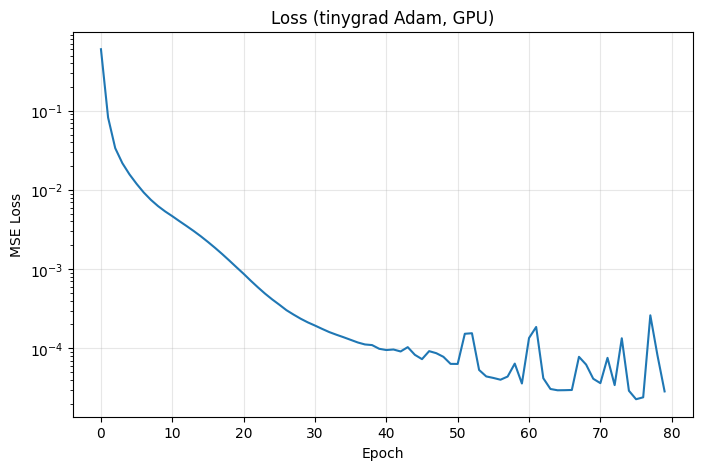

Pred: [-0.20085521  1.4042189 ]
Exp : [-0.2   1.41]
Abs err: [0.00085521 0.00578105]


In [4]:
from tinygrad import Tensor, Device
from tinygrad.nn.optim import Adam
import numpy as np
import matplotlib.pyplot as plt

print("Device:", Device.DEFAULT)

# ✅ notwendig für Optimizer.step()
Tensor.training = True

# -----------------------
# Data
# -----------------------
n = 100_000
X_np = np.random.uniform(-1, 1, (n, 2)).astype(np.float32)
q1, q2 = X_np[:, 0], X_np[:, 1]
Y_np = np.stack([q1 + q2 - 1.0, q1 - q2**2 + 1.0], axis=1).astype(np.float32)

# -----------------------
# Model
# -----------------------
class MLP:
    def __init__(self):
        def w(in_dim, out_dim):
            # scaled init for tanh
            return Tensor.randn(in_dim, out_dim, requires_grad=True) * np.sqrt(1.0 / in_dim)

        self.w1, self.b1 = w(2, 128), Tensor.zeros(128, requires_grad=True)
        self.w2, self.b2 = w(128, 128), Tensor.zeros(128, requires_grad=True)
        self.w3, self.b3 = w(128, 64),  Tensor.zeros(64,  requires_grad=True)
        self.w4, self.b4 = w(64, 2),    Tensor.zeros(2,   requires_grad=True)

    def __call__(self, x):
        x = (x @ self.w1 + self.b1).tanh()
        x = (x @ self.w2 + self.b2).tanh()
        x = (x @ self.w3 + self.b3).tanh()
        x = (x @ self.w4 + self.b4)   # linear output
        return x

model = MLP()
params = [model.w1, model.b1, model.w2, model.b2, model.w3, model.b3, model.w4, model.b4]

opt = Adam(params, lr=1e-3)

# -----------------------
# Training
# -----------------------
epochs = 80
batch_size = 4096
loss_history = []

for epoch in range(epochs):
    perm = np.random.permutation(n)
    epoch_loss = 0.0
    nb = 0

    for start in range(0, n, batch_size):
        idx = perm[start:start+batch_size]
        xb = Tensor(X_np[idx], device=Device.DEFAULT)
        yb = Tensor(Y_np[idx], device=Device.DEFAULT)

        pred = model(xb)
        loss = ((pred - yb) ** 2).mean()

        opt.zero_grad()
        loss.backward()
        opt.step()

        epoch_loss += loss.item()
        nb += 1

    epoch_loss /= nb
    loss_history.append(epoch_loss)
    if epoch % 5 == 0:
        print(f"Epoch {epoch:03d} | loss={epoch_loss:.6e}")

# -----------------------
# Plot
# -----------------------
plt.figure(figsize=(8, 5))
plt.plot(loss_history)
plt.yscale("log")
plt.grid(True, alpha=0.3)
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Loss (tinygrad Adam, GPU)")
plt.show()

# -----------------------
# Test
# -----------------------
test_np = np.array([[0.5, 0.3]], dtype=np.float32)
pred = model(Tensor(test_np, device=Device.DEFAULT)).numpy()[0]
exp = np.array([0.5 + 0.3 - 1.0, 0.5 - 0.3**2 + 1.0], dtype=np.float32)

print("Pred:", pred)
print("Exp :", exp)
print("Abs err:", np.abs(pred - exp))
